# Species distribution modeling for Solanum Acaule
## An example of a Python data analysis project in a Jupyter notebook

### 1. Overview
This notebook creates a species distribution model for Solanum Acaule, a plant species growing in the western countries of South America, with the help of the R dismo package and illustrates the predicted distribution with an interactive map based on ESRI's ArcGIS API for Python and ArcGIS Online (AGOL). The notebook adapts an example from https://rspatial.org/raster/sdm/index.html by Robert J Hijmans and Jane Elith. The main goal is to demonstrate how Python, R, and different 3rd party Python packages can be combined in a Jupyter notebook to solve and document a spatial data analysis task. To limit length and complexity for the purposes of this Python programming course, we made various simplifications from the perspective of species distribution modeling.

The project and remainder of this notebook are organized into the following five steps/sections: project preparation (Section 2), obtaining and cleaning observation data for Solanum Acaule (Section 3), preparation of other input data (Section 4), creating and running the model in R (Section 5), and postprocessing and visualization of the results with AGOL (Section 6).

The code has been implemented and tested with Python 3.6. The last part (Section 6) requires a pennstate AGOL account (https://www.arcgis.com/home/index.html).

Python packages used:
* from the Python standard library: 
 * os (https://docs.python.org/3/library/os.html)
 * re (https://docs.python.org/3/library/re.html)
 * zipfile (https://docs.python.org/3/library/zipfile.html)
* rpy2 (https://pypi.python.org/pypi/rpy2)
* numpy (https://pypi.python.org/pypi/numpy)
* matplotlib (https://pypi.python.org/pypi/matplotlib)
* cartopy (https://pypi.org/project/Cartopy/)
* pandas (https://pypi.python.org/pypi/pandas)
* geopandas (https://pypi.python.org/pypi/geopandas)
* Shapely (https://pypi.python.org/pypi/Shapely)
* GDAL/OGR (https://pypi.python.org/pypi/GDAL)  
* arcgis - ArcGIS API for Python (https://developers.arcgis.com/python/)

R packages used:
* dismo (https://cran.r-project.org/web/packages/dismo/index.html)
* maptools (https://cran.r-project.org/web/packages/maptools/index.html)
* rgdal (https://cran.r-project.org/web/packages/rgdal/index.html)

### 2. Preparation
To run this notebook, you will have to make sure that a number of Python packages are installed as described above and that you downloaded and extracted the input data we are going to use to a new folder (referred to as the workspace folder in the following). Furthermore, you will have to adapt a number of input variables in Section 2.3.1 of this notebook. 

#### 2.1 Python packages to install

The notebook has been developed in the fresh Anaconda Python 3.6 environment created in Section 3.2. of the lesson materials. Installing the Python packages needed for the project (see Section 1 above) required adding two additional channels, conda-forge and esri, in Anaconda. If you followed the instructions from Section 3.2 of the lesson materials, you should already have all the required Python packages installed.

#### 2.2 Data for this project

The data for this project is available as a .zip file linked in Section 3.11 of the lesson materials. You should extract the files contained in the .zip file to a new folder. You will then need to set the *workspace* variable in Section 2.3.1 of this notebook to refer to this folder. 

The data consists of a world borders shapefile and a set of raster files for different bioclimatic variables available from https://www.worldclim.org/data/index.html [1].

<sup>[1] Fick, S.E. and R.J. Hijmans, 2017. Worldclim 2: New 1-km spatial resolution climate resolution climate surfaces for global land areas. International Journal of Climatology. </sup>

#### 2.3 Importing packages and preparing notebook
The following subsections contain some first Python code to initialize the project, starting with some important input variables that you need to adapt for your purposes.


##### 2.3.1 Set up input variables that need to be adapted by user
The workspace variable should point to the folder to which you extracted the input data. **Please adapt the path accordingly.**

In [1]:
workspace = r'C:\489\L3\walkthrough' 

Username for your pennstate organization account. We will need this later to visualize our results. **Please fill in your username PSU ID in place of the asterisk.**

In [3]:
usernameAGOL = '*_pennstate' 

The following two input variables contain the names of output shapefiles produced in later parts of the notebook that will be uploaded to your AGOL account. **Please replace the asterisks in the names with your initials or PSU ID to make sure the names are unique in the organization.**

In [49]:
acauleObservationShapefile = 'acauleObservations_*.shp'  # name of ouput observation shapefile produced in Section 6.1
predictionShapefile = 'bioclimPrediction_*.shp'          # name of shapefile with polygonized version of prediction produced in Section 6.2

##### 2.3.2 Set up other input variables 
The following input variables are for names of input and output files, etc. They can be left unchanged:

In [5]:
worldCountryShapefile = 'TM_WORLD_BORDERS-0.3.shp'     # name of country shapefile used in Section 3
predictionRasterFile = 'bioclim_prediction.tif'        # name of raster file with bioclim prediction produced in Section 5.2

##### 2.3.3 Import general Python packages needed
Here we import some Python packages that we will use in different places throught the project:

In [6]:
import os, re, sys
import numpy as np

##### 2.3.4 R interface and packages
To make sure that we can access R and the 'dismo' package from within our Python notebook, we have to set up rpy2 and load 'dismo', 'maptools', and 'rgdal'. We recently had cases where loading rpy2 failed on some systems due to the R_HOME environment variable not being set correctly. We therefore added the first line below which **you will have to adapt to point to the lib\R folder in your AC Python environment** (at the very least, you will have to replace username with your actual Windows user name).

In [8]:
# load rpy2.ipython extension for easy interfacing to R 
os.environ['R_HOME'] = r'C:\Users\username\anaconda3\envs\AC37\lib\R' # workaround for R.dll issue occurring on some systems
%load_ext rpy2.ipython

C:\Users\jow\anaconda3\envs\AC37\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


Our Anaconda environment currently already contains the dismo and maptools R packages but not the rgdal package (see explanation in Section 3.11 of the lesson materials). To install the rgdal R package, run the following %R command. A window will open up that allows you to pick the mirror from which to install. The installation may take a little while.

In [9]:
%R install.packages('rgdal')

--- Please select a CRAN mirror for use in this session ---

  There is a binary version available but the source version is later:
      binary source needs_compilation
rgdal 1.5-31 1.5-32              TRUE

  Binaries will be installed


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.0/rgdal_1.5-31.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 45218217 bytes (43.1 MB)

R[write to console]: downloaded 43.1 MB




package 'rgdal' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jow\AppData\Local\Temp\RtmpSOan0c\downloaded_packages


The next commands make sure all three R packages needed are loaded. If one of these commands returns "array(\[0\], dtype=int32)" instead of array(\[1\], dtype=int32), there is a problem with this R package and you may have to skip over some parts of this notebook, see note in Section 3.11 of the lesson materials.

In [10]:
# make sure the maptools R package is installed and load it
%R require('maptools')

R[write to console]: Loading required package: maptools

R[write to console]: Loading required package: sp

R[write to console]: Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()



1


In [11]:
# make sure the rgdal R package is installed and load it
%R require('rgdal')

R[write to console]: Loading required package: rgdal

R[write to console]: Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-31, (SVN revision 1171)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.4.1, released 2021/12/27
Path to GDAL shared files: C:/Users/jow/anaconda3/envs/AC37/lib/R/library/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 7.2.1, January 1st, 2021, [PJ_VERSION: 721]
Path to PROJ shared files: C:\Users\jow\anaconda3\envs\AC37\Library\share\proj
PROJ CDN enabled: TRUE
Linking to sp version:1.4-7
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading sp or rgdal.



1


In [12]:
# make sure the dismo R package is installed and load it
%R require('dismo')

R[write to console]: Loading required package: dismo

R[write to console]: Loading required package: raster

R[write to console]: code for methods in class "Rcpp_SpExtent" was not checked for suspicious field assignments (recommended package 'codetools' not available?)

R[write to console]: code for methods in class "Rcpp_SpExtent" was not checked for suspicious field assignments (recommended package 'codetools' not available?)

R[write to console]: code for methods in class "Rcpp_SpPoly" was not checked for suspicious field assignments (recommended package 'codetools' not available?)

R[write to console]: code for methods in class "Rcpp_SpPoly" was not checked for suspicious field assignments (recommended package 'codetools' not available?)

R[write to console]: code for methods in class "Rcpp_SpPolyPart" was not checked for suspicious field assignments (recommended package 'codetools' not available?)

R[write to console]: code for methods in class "Rcpp_SpPolyPart" was not checked fo

1


### 3. Obtaining and cleaning observation data
In most species distribution modeling projects, you would probably already have a data set available that contains information on where that species has been observed (presence data) and maybe also where it hasn't been observed (absence data). In this project, however, we are going to instead use data from the Global Biodiversity Inventory Facility (GBIF) at www.gbif.org that provides free access to a large repository of biodiversity data. 

Dismo provides a function *gbif(...)* to directly download  data from GBIF for convenience (see page 22 of the dismo package documentation at https://cran.r-project.org/web/packages/dismo/dismo.pdf ). The function allows for specifying the genus (solanum) and species (acaule) that we are interested in. However, for this walkthrough we won't be using a newly downloaded data set from GBIF, but rather a smaller example data set for Solanum Acaule provided as part of the dismo package which is better suited to illustrate the different steps in this walkthrough. We will then maintain the obtained presence data in a pandas data frame, inspect it, and apply different approaches to clean up the data a bit before we make use of it.

#### 3.1 Acquiring the observation data and transferring it to a pandas data frame

**Note: For the case that you run into any issues with executing the R commands in this subsection (which most likely means you weren't able to load the dismo package in Section 2.3.4 above), we are providing a workaround at the end of this subsection that reads in the data from a csv file in Python rather than using R and the dismo package.**

To get the data for Solanum Acaule as an R data frame, we simply have to call the *data(...)* function provided by dismo with the name of the variable (*acaule*) that we want to store the data frame in. We use the R function *head(...)* to only show the first six rows of the table here. If you run the second line without the *head(..)* and scroll down to the end of the table, you will see that the data frame has 1366 rows and 25 columns in total.

In [13]:
%R data(acaule)
%R head(acaule)

,species,continent,country,adm1,adm2,locality,lat,lon,coordUncertaintyM,alt,...,earliestDateCollected,latestDateCollected,gbifNotes,downloadDate,maxElevationM,minElevationM,maxDepthM,minDepthM,ISO2,cloc
1,Solanum acaule Bitter,South America,Argentina,Jujuy,Santa Catalina,Santa Catalina: camino de salida del pueblo,-21.9000,-66.1000,None,NaN,...,1979-01-29,1979-01-29,Data from GBIF data index - original values.,15721.0,None,None,None,None,AR,"Santa Catalina: camino de salida del pueblo, J..."
2,Solanum acaule Bitter,South America,Peru,Cusco,Canchis,"Dist. Sicuani, Santa Barbara, Mumurani.",-13.5000,-71.0000,None,4500.0,...,2005-03-17,2005-03-17,Data from GBIF data index - original values.,15721.0,4500,4500,None,None,PE,"Dist. Sicuani, Santa Barbara, Mumurani., Cusco..."
3,Solanum acaule f. acaule,None,Argentina,None,None,"Province: Salta, Department: Santa Victoria, E...",-22.2666,-65.1333,None,3800.0,...,None,None,Data from GBIF data index - original values.,15721.0,None,3800,None,None,AR,"Province: Salta, Department: Santa Victoria, E..."
4,Solanum acaule f. acaule,None,Bolivia,None,None,"Department: Oruro, Province: Poopo, farm (Fink...",-18.6333,-66.9500,None,3700.0,...,None,None,Data from GBIF data index - original values.,15721.0,None,3700,None,None,BO,"Department: Oruro, Province: Poopo, farm (Fink..."
5,Solanum acaule f. acaule,None,Bolivia,None,None,"Department: Potosi, Province: Chayanta, 37km f...",-18.8000,-65.8833,None,4080.0,...,None,None,Data from GBIF data index - original values.,15721.0,None,4080,None,None,BO,"Department: Potosi, Province: Chayanta, 37km f..."
6,Solanum acaule f. acaule,None,Bolivia,None,None,"Department: Potosi, Province: Chayanta, 4km fr...",-18.8333,-65.8833,None,3780.0,...,None,None,Data from GBIF data index - original values.,15721.0,None,3780,None,None,BO,"Department: Potosi, Province: Chayanta, 4km fr..."


Next, we want to move the entire table to Python to work with it there, more precisely we want to transfer it to a pandas DataFrame object. To achieve this we need to import pandas as well as activate some component of rpy2 that will make sure that R data frames are correctly translated into pandas data frames:

In [14]:
import pandas as pd                  

from rpy2.robjects import pandas2ri  # activate pandas R  interface
pandas2ri.activate()

Now we can move the table to Python by using '%R' with the '-o' option as explained in Section 3.7 of the lesson materials:

In [15]:
%R -o acaule

For now we are done with using R. We now have a Python variable called *acaule* that contains the entire observation table and that is a pandas DataFrame object as can be easily verified. We use the pandas *head()* method to only show the first five rows of the table here:

In [16]:
print(type(acaule))        # print the type of variable acaule
acaule.head()              # show the content of the DataFrame object

<class 'pandas.core.frame.DataFrame'>


,species,continent,country,adm1,adm2,locality,lat,lon,coordUncertaintyM,alt,...,earliestDateCollected,latestDateCollected,gbifNotes,downloadDate,maxElevationM,minElevationM,maxDepthM,minDepthM,ISO2,cloc
1,Solanum acaule Bitter,South America,Argentina,Jujuy,Santa Catalina,Santa Catalina: camino de salida del pueblo,-21.9000,-66.1000,None,NaN,...,1979-01-29,1979-01-29,Data from GBIF data index - original values.,15721.0,None,None,None,None,AR,"Santa Catalina: camino de salida del pueblo, J..."
2,Solanum acaule Bitter,South America,Peru,Cusco,Canchis,"Dist. Sicuani, Santa Barbara, Mumurani.",-13.5000,-71.0000,None,4500.0,...,2005-03-17,2005-03-17,Data from GBIF data index - original values.,15721.0,4500,4500,None,None,PE,"Dist. Sicuani, Santa Barbara, Mumurani., Cusco..."
3,Solanum acaule f. acaule,None,Argentina,None,None,"Province: Salta, Department: Santa Victoria, E...",-22.2666,-65.1333,None,3800.0,...,None,None,Data from GBIF data index - original values.,15721.0,None,3800,None,None,AR,"Province: Salta, Department: Santa Victoria, E..."
4,Solanum acaule f. acaule,None,Bolivia,None,None,"Department: Oruro, Province: Poopo, farm (Fink...",-18.6333,-66.9500,None,3700.0,...,None,None,Data from GBIF data index - original values.,15721.0,None,3700,None,None,BO,"Department: Oruro, Province: Poopo, farm (Fink..."
5,Solanum acaule f. acaule,None,Bolivia,None,None,"Department: Potosi, Province: Chayanta, 37km f...",-18.8000,-65.8833,None,4080.0,...,None,None,Data from GBIF data index - original values.,15721.0,None,4080,None,None,BO,"Department: Potosi, Province: Chayanta, 37km f..."


##### Workaround for 3.1 (skip this part if everything above worked ok for you)
As we noted in Section 3.11 of the lesson materials, it is possible that you into issues with running the R commands in this section due to some issues with the R packages involved. If this is the case, you can run the following Python code to read in the acaule observation data from the csv file we are providing in Section 3.11. Depending on where you have placed that file on your harddisk, you may to adapt the path in the second line of the code.

In [ ]:
import pandas 
acaule = pandas.read_csv(r'C:\geog489\L3\L3_walkthrough_data\acaule.csv')
acaule.head()

#### 3.2 Investigating the observation data
Now that we are back in Python, let's apply what we learned about working with pandas data frames to look at the data a bit in more detail. Let's start by looking at the column labels to get a better idea of what information we have available:

In [17]:
acaule.columns

Index(['species', 'continent', 'country', 'adm1', 'adm2', 'locality', 'lat',
       'lon', 'coordUncertaintyM', 'alt', 'institution', 'collection',
       'catalogNumber', 'basisOfRecord', 'collector', 'earliestDateCollected',
       'latestDateCollected', 'gbifNotes', 'downloadDate', 'maxElevationM',
       'minElevationM', 'maxDepthM', 'minDepthM', 'ISO2', 'cloc'],
      dtype='object')

The most important columns for our species distribution modeling task are the latitude and longitude WGS84 coordinates stored in the 'lat' and 'lon' columns. Furthermore, we will later use the 'country' column to perform a quick plausibility check of the coordinates. Let's see again how many rows we now have in our table: 

In [18]:
len(acaule)

1366

1366 rows. Unfortunately, when we take a closer look at the 'lat' and 'lon' columns, we see that not all the rows contain latitude and longitude coordinates. In the following command, we use [ ['lat', 'lon'] ]  to restrict the columns to the 'lat' and 'lon' columns and [300:306] to slice the rows to only those with indices 300 to 305 (= row numbers 301 to 306 because the row labels start with 1, while the index starts counting from 0). 

In [19]:
acaule[ ['lat','lon'] ][300:306] 

,lat,lon
301,NaN,NaN
302,-16.217,-68.867
303,-76.300,-76.300
304,-10.070,-77.180
305,NaN,NaN
306,-14.680,-74.120


The NaN stands for 'not a number' and is the result of no value being provided for these entries in the GBIF data. This is something we will have to take care of because we cannot use these records when applying a distribution model. We picked rows 301 to 306 in the previous cell because we already knew these rows contain NaN entries. Luckily, it's easy to test whether a column contains such entries using the pandas *notnull()* method:

In [20]:
print(acaule.lat.isnull().value_counts())
print(acaule.lon.isnull().value_counts())

False    1082
True      284
Name: lat, dtype: int64
False    1082
True      284
Name: lon, dtype: int64


What happens here is that we apply *isnull()* to the acaule.lat and acaule.lon columns which gives us a boolean vector with True for rows that have NaN in the respective column and False otherwise, and then we apply the *value_counts()* method which gives us an overview of how often each value occurs in a data frame or, in this case, boolean vector. So we now know that the table contains 284 rows with a latitude value of NaN, and the same for the longitude values.

Finally, to get a quick idea of where the observations are located, we will use matplotlib in combination with cartopy to create a scatterplot of the 'lon' and 'lat' coordinate pairs on top of a simple world map (if you get some string output instead of a map image, run the code in this cell a second time):

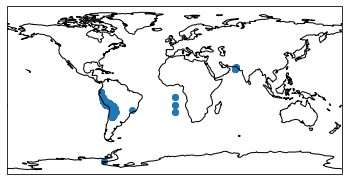

In [21]:
# use matplotlib and cartopy to plot data on map
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

m = plt.axes(projection=ccrs.PlateCarree()) # create a new empty map object
m.coastlines()                              # add coast lines to map
m.set_global()                              # set zoom to show the entire map
m.scatter(acaule['lon'],acaule['lat'])      # create vectors of lon and lat coordinates from our acaule table 
                                            #   and draw them as points
plt.show()                                  # plot the map

As you can see, the resulting plot is directly embedded as an image into the notebook. This is a very simple but also very useful approach to quickly plot some data, and we will use it a few times more in this notebook. When we look at the data, we  can see that there are a few suspicuous outliers that we should better take a closer look at before using this data to create our model.

#### 3.3 Cleaning the observation data
When looking at the observation data in the previous section, we already identified a number of problematic entries which is often the case due to human error when creating the data or when compiling it by combining data from different sources. While 100% perfect data is often unachievable, in particular for large data sets, there are a number measures that can be taken to clean up the data by correcting mistakes or removing incomplete or erroneous entries. In the following we will show a few examples of how Python code can be used to validate and clean up our observation data.

##### 3.3.1 Removing rows without lon or lat coordinates
As we saw above, there exist entries in our observation table that do not have longitude and latitude coordinates specified, showing up as NaN ("not a number") in the table data. Let's start the cleaning process by removing these. As we already showed, the pandas method *notnull()* can be used to test that cells do not contain NaN and can be applied to a column or data frame to give us a boolean column/data frame as result. So if we want to test how many rows need to be removed we can use the filtering based on boolean expressions approach discussed in Section 3.8.6:

In [22]:
nanRows = acaule[ ~ ( acaule.lat.notnull() & acaule.lon.notnull() ) ]
print('Number of nan rows:' + str(len(nanRows)))
nanRows.head()

Number of nan rows:284


,species,continent,country,adm1,adm2,locality,lat,lon,coordUncertaintyM,alt,...,earliestDateCollected,latestDateCollected,gbifNotes,downloadDate,maxElevationM,minElevationM,maxDepthM,minDepthM,ISO2,cloc
266,solanum acaule acaule,None,Namibia,None,None,None,NaN,NaN,None,NaN,...,None,None,Data from GBIF data index - original values.,15721.0,None,None,None,None,None,Namibia
268,solanum acaule acaule,None,Namibia,None,None,None,NaN,NaN,None,NaN,...,None,None,Data from GBIF data index - original values.,15721.0,None,None,None,None,None,Namibia
270,solanum acaule acaule,None,Namibia,None,None,None,NaN,NaN,None,NaN,...,None,None,Data from GBIF data index - original values.,15721.0,None,None,None,None,None,Namibia
273,solanum acaule acaule,None,Namibia,None,None,None,NaN,NaN,None,NaN,...,None,None,Data from GBIF data index - original values.,15721.0,None,None,None,None,None,Namibia
276,solanum acaule acaule,None,Namibia,None,None,None,NaN,NaN,None,NaN,...,None,None,Data from GBIF data index - original values.,15721.0,None,None,None,None,None,Namibia


This may look a bit complicated but what we do here within the squared brackets is just producing two boolean vectors: one that has True for all rows that have a latitude value (lat) that satisfies the notnull criterion, and one that does the same for the longitude (lon) column, and then the & operator is used to combine these into a single boolean vector using logical AND. This gives us a boolean vector for the rows that we actually want to keep, so to get those that need to be removed we invert the vector using the ~ operator for logical negation. Finally, by writing acaule[...] the resulting boolean vector is used to filter the data frame to only show those rows we are interested in. The output from the print command in line 2 tells us that there are 284 rows in total that need to be removed.

Now to actually remove the rows, we do the same thing but without the negation part and assign the result to a new variable acauleWithCoordinates:

In [23]:
acauleWithCoordinates = acaule[ acaule.lat.notnull() & acaule.lon.notnull() ]
print('Rows remaining:' + str(len(acauleWithCoordinates)))
acauleWithCoordinates.head()

Rows remaining:1082


,species,continent,country,adm1,adm2,locality,lat,lon,coordUncertaintyM,alt,...,earliestDateCollected,latestDateCollected,gbifNotes,downloadDate,maxElevationM,minElevationM,maxDepthM,minDepthM,ISO2,cloc
1,Solanum acaule Bitter,South America,Argentina,Jujuy,Santa Catalina,Santa Catalina: camino de salida del pueblo,-21.9000,-66.1000,None,NaN,...,1979-01-29,1979-01-29,Data from GBIF data index - original values.,15721.0,None,None,None,None,AR,"Santa Catalina: camino de salida del pueblo, J..."
2,Solanum acaule Bitter,South America,Peru,Cusco,Canchis,"Dist. Sicuani, Santa Barbara, Mumurani.",-13.5000,-71.0000,None,4500.0,...,2005-03-17,2005-03-17,Data from GBIF data index - original values.,15721.0,4500,4500,None,None,PE,"Dist. Sicuani, Santa Barbara, Mumurani., Cusco..."
3,Solanum acaule f. acaule,None,Argentina,None,None,"Province: Salta, Department: Santa Victoria, E...",-22.2666,-65.1333,None,3800.0,...,None,None,Data from GBIF data index - original values.,15721.0,None,3800,None,None,AR,"Province: Salta, Department: Santa Victoria, E..."
4,Solanum acaule f. acaule,None,Bolivia,None,None,"Department: Oruro, Province: Poopo, farm (Fink...",-18.6333,-66.9500,None,3700.0,...,None,None,Data from GBIF data index - original values.,15721.0,None,3700,None,None,BO,"Department: Oruro, Province: Poopo, farm (Fink..."
5,Solanum acaule f. acaule,None,Bolivia,None,None,"Department: Potosi, Province: Chayanta, 37km f...",-18.8000,-65.8833,None,4080.0,...,None,None,Data from GBIF data index - original values.,15721.0,None,4080,None,None,BO,"Department: Potosi, Province: Chayanta, 37km f..."


Of the original 1366 rows we now have 1082 rows remaining, so we correctly removed the 284 rows that have NaN for the lat or lon column.

##### 3.3.2 Duplicate removal

One thing that can often happen when data is compiled from different sources with different people contributing is that records are duplicated and end up multiple times in the table data. Pandas provides a method for checking for duplicates in a data frame, so let's quickly apply that to our data. The method is called *duplicated(...)* (http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html ). It gives back a boolean vector that contains True if the corresponding row is a duplicate of another one and False otherwise. When calling the method, we will not provide the 'subset' parameter so that pandas will look at all columns for deciding whether two rows are identical or not. We will, however, use the parameter 'keep' to say that the first entry of those that are deemed identical will not be assigned True in the output. That means if there are five rows that are the same, the first of these will appear as False in the output boolean vector, while all the others will appear as True. So if we would use the result to filter the rows, we would keep exactly one (the first) of the identical rows in our table.

In [24]:
isDuplicate = acauleWithCoordinates.duplicated(keep = 'first')
print(isDuplicate.head())
isDuplicate.value_counts()

1    False
2    False
3    False
4    False
5    False
dtype: bool


False    1082
dtype: int64

By applying the *value_counts()* method to the result of *duplicated(...)* we can immediately see that the vector consists of only False, so there are actually no duplicates in our data that we need to filter out.

##### 3.3.3 Plausibility check of countries and coordinates
When we plotted the lat, lon coordinates on a map, we already noticed some weird outliers such as points in the Atlantic and Indian Ocean and in the Antartica. This can often be the result of mistakes made when entering the coordinates such as accidentally swapping lat and lon coordinates, forgetting a minus sign, etc. 

Our data provides a column with the name of the country in which the observation took place, so this gives us the option to run a simple plausibility test to check whether country and coordinates are consistent. However, to do this, we need a way to geocode WGS84 coordinates to the country that contains these coordinates. There are multiple options how we can realize this kind of geocoding in our Python code. One option would be to use an existing geocoding service such as Google's geocoding API or ESRI's *reverse_geocode(...)* function provide as part of the ArcGIS API for Python package. However, these options have certain disadvantages such as having a limit of how many requests can be made freely in a certain time span (which is problematic given the larger number points on our data set and the fact that we may want to be able to run the notebook code repeatedly) and the fact that these typically work by finding the closest address to the given point which does not always give the correct results for sparsely populated areas close to the border of two countries.

We therefore opted to use an approach based on a local shapefile with polygons for all countries to implement the geocoding of coordinates to country names. The shapefile is called TM_WORLD_BORDERS-0.3.shp (see variable *worldCountryShapefile* defined in Section 2.3.2) and is part of the project data you had to extract, so it should be in your workspace folder now. Fortunately, the GDAL/OGR package (Section 3.9 of the lesson materials) contains all the methods we will need to query a shapefile with a point to get the polygon from the shapefile that contains that point. As the first step, we will use the OGR package of GDAL to open the world borders shapefile and access its only layer. Then we will determine the indices of the columns we are interested in ('NAME' for the countries' names) and for our observation data frame ('country' for the names of the country the observation was made in, 'lat' and 'lon' for the coordinates). To get the index of a column in a vector data set with OGR, we need to call the *GetLayerDefn()* method and then invoke *GetFieldIndex(...)* to get the index. For our observation data frame, we use the *get_loc(...)* method on the *columns* property of our data frame.

In [25]:
from osgeo import ogr

# open shapefile containing country polygons
filename = os.path.join(workspace, worldCountryShapefile)
drv = ogr.GetDriverByName('ESRI Shapefile')                     # set up driver object to read/write shapefiles
shapefile = drv.Open(filename)                                  # open shapefile
layer = shapefile.GetLayer(0)                                   # create layer object for shapefile

# determine indices of relevant columns
nameIndex = layer.GetLayerDefn().GetFieldIndex('NAME')                # index of column with country names in shapefile 

countryIndex = acauleWithCoordinates.columns.get_loc('country')       # index of country name column in observation table                                                            
latIndex = acauleWithCoordinates.columns.get_loc('lat')               # index of lat column in observation table
lonIndex = acauleWithCoordinates.columns.get_loc('lon')               # index of lon column in observation table

# print out the results
print('nameIndex: {0}, countryIndex: {1}, latIndex: {2}, lonIndex: {3}'.format(nameIndex, countryIndex, latIndex, lonIndex))           

nameIndex: 4, countryIndex: 2, latIndex: 6, lonIndex: 7


We will now loop through the rows in our observation data frame with *itertuples()* to create a list of country names in variable *geocodingResults* that for each row provides the name of the country from the world borders shapefile that contains the corresponding coordinates. We will use the OGR's ability to set a spatial filter for a layer with *layer.SetSpatialFilter(point)* to reduce the country polygons to only that polygon that intersects with a given point feature. The other relevant GDAL/OGR methods we will use for this are:
* *ogr.Geometry(ogr.wkbPoint)* to create a new point feature
* *SetPoint_2D(...)*  to set the coordinate of that point 
* *GetFeatureCount()* to get the number of active features after applying the spatial filter
* *GetNextFeature()* to get the first polygon feature from the result of applying the spatial filter
* *GetFieldAsString(...)* to get the content of the 'NAME' field as a string

In [26]:
# set up list in which we will store the results of looking up the containing country for each row
geocodingResults = []  

# itertuples is used to efficiently loop through the rows of the data frame
for row in acauleWithCoordinates.itertuples(index=False):  

    # create a new OGR point object with lon and lat coordinates from current row 
    pt = ogr.Geometry(ogr.wkbPoint)                    
    pt.SetPoint_2D(0, row[lonIndex], row[latIndex] )  

    # apply spatial filter that will give us polygons that intersect our point
    layer.SetSpatialFilter(pt)                         

    country = "UNKNOWN"           # variable for storing the country's name

    # check whether there's exactly one feature selected, if get country name of that feature
    if layer.GetFeatureCount() == 1:                   
        country = layer.GetNextFeature().GetFieldAsString(nameIndex)
    
    # add country name to result list
    geocodingResults.append(country)                   
    
# show the first five elements of the resulting list of country names
geocodingResults[0:5]

['Argentina', 'Peru', 'Argentina', 'Bolivia', 'Bolivia']

Please note that with the way the code in the previous cell is written, the geocoding result will be "UNKNOWN" for rows for which no containing polygon could be found in the world borders shapefile. You will actually find such entries if you change the last line to show the complete list. 

The reason why we are storing the results of looking up the containing polygon for the observation points in a list is that we want to add a new column with these results to our data frame. While this isn't absolutely necessary, it means we will always have these intermediate results available and we can archive everything together as a single csv or shapefile on disk. However, it is important to note that our result list only contains entries for the active rows in *acauleWithCoordinates* but not the rows that we filtered out in Section 3.3.1 because they didn't contain lat/lon coordinates. These rows still exist, they are just not visible in *acauleWithCoordinates*, but this means that we would run into issues when we add *geocodingResults* as a new column to *acauleWithCoordinates* because of mismatching row numbers. Therefore, we are first going to clone the *acauleWithCoordinates* data frame which will give us a new data frame with only the active rows and columns that we then store in variable *acauleWithGeocoding*. We then add the geocoding results as a new column called 'country_geocoding' to this new data frame.

In [27]:
acauleWithGeocoding = acauleWithCoordinates.copy()           # clone data frame, only active rows and columns remain
acauleWithGeocoding['country_geocoding'] = geocodingResults  # add geocoding results as new column
acauleWithGeocoding.head()

,species,continent,country,adm1,adm2,locality,lat,lon,coordUncertaintyM,alt,...,latestDateCollected,gbifNotes,downloadDate,maxElevationM,minElevationM,maxDepthM,minDepthM,ISO2,cloc,country_geocoding
1,Solanum acaule Bitter,South America,Argentina,Jujuy,Santa Catalina,Santa Catalina: camino de salida del pueblo,-21.9000,-66.1000,None,NaN,...,1979-01-29,Data from GBIF data index - original values.,15721.0,None,None,None,None,AR,"Santa Catalina: camino de salida del pueblo, J...",Argentina
2,Solanum acaule Bitter,South America,Peru,Cusco,Canchis,"Dist. Sicuani, Santa Barbara, Mumurani.",-13.5000,-71.0000,None,4500.0,...,2005-03-17,Data from GBIF data index - original values.,15721.0,4500,4500,None,None,PE,"Dist. Sicuani, Santa Barbara, Mumurani., Cusco...",Peru
3,Solanum acaule f. acaule,None,Argentina,None,None,"Province: Salta, Department: Santa Victoria, E...",-22.2666,-65.1333,None,3800.0,...,None,Data from GBIF data index - original values.,15721.0,None,3800,None,None,AR,"Province: Salta, Department: Santa Victoria, E...",Argentina
4,Solanum acaule f. acaule,None,Bolivia,None,None,"Department: Oruro, Province: Poopo, farm (Fink...",-18.6333,-66.9500,None,3700.0,...,None,Data from GBIF data index - original values.,15721.0,None,3700,None,None,BO,"Department: Oruro, Province: Poopo, farm (Fink...",Bolivia
5,Solanum acaule f. acaule,None,Bolivia,None,None,"Department: Potosi, Province: Chayanta, 37km f...",-18.8000,-65.8833,None,4080.0,...,None,Data from GBIF data index - original values.,15721.0,None,4080,None,None,BO,"Department: Potosi, Province: Chayanta, 37km f...",Bolivia


The new column appears as the very last column of the data frame, so you will have to scroll the table output from the previous cell all the way to the right to see it. Now, it's finally time to check for entries for which the geocoding result and the name of the country we find in the 'country' column do not match. We again use boolean indexing to achieve this. The boolean vector is constructed by the expression 

acauleWithGeocoding.country_geocoding != acauleWithGeocoding.country

which compares corresponding cells of the 'country_geocoding' and 'country' columns. The resulting boolean vector will contain True for rows where the two names do **not** match (because we are using *not equal* (!=) as the comparison operator) and False otherwise. So we can directly use it to get only the mismatches by using the resulting vector to filter *acauleWithGeocoding*:

In [28]:
# entries where geocoding and country field don't match
mismatches = acauleWithGeocoding[ acauleWithGeocoding.country_geocoding != acauleWithGeocoding.country ]
mismatches[['country','country_geocoding']]

,country,country_geocoding
98,Bolivia,Brazil
303,Antarctica,UNKNOWN
446,Peru,Bolivia
614,Peru,Bolivia
657,Peru,Bolivia
728,Peru,Bolivia
762,Peru,Bolivia
782,Peru,Bolivia
885,Peru,UNKNOWN
949,Argentina,UNKNOWN


From printing out the 'country' and 'country_geocoding' columns of the mismatches, we can see that most of them are UNKNOWN cases where no containing country was found. In addition, we have cases where the two involved countries are neighbored countries, so a possible explanation could be that these observations were made very close to the common border between the countries, so that small deviations or imprecisions in the world country polygons could have led to the differing results.

Let's quickly use the approach we used before and draw the mismatches on a map with matplotlib:

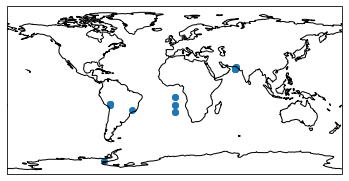

In [29]:
m = plt.axes(projection=ccrs.PlateCarree())
m.coastlines()
m.set_global()
m.scatter(mismatches['lon'],mismatches['lat'])
plt.show()

We can see that the suspicious cases we already observed before are contained in these mismatches. We get UNKNOWN results because most them fall into water.  One other thing we can see is that the observation with geocoding result 'Brazil' is actually quite far away from the Bolivian border.

In principle, we could now further inspect these mismatching cases and try to correct them, e.g. by figuring out whether some of them are due to swapping lat/lon coordinates or similar reasons. But instead, we are going to go with the easier approach of simply removing all of them, except for those Peru-Bolivia pairs where we assumed these were collected close to the common border. That means we want to keep all rows for which 'country_geocoding' and 'country' match (comparison operator ==) or (logical operator |) for which 'country_geocoding' equals 'Bolivia'. The resulting expression for the boolean indexing (Section 3.8.6 from the lesson materials) can be seen in the code below that also prints out the number of remaining rows and draws the result on a map.

rows in acauleClean: 1064


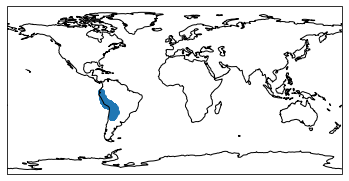

In [30]:
# keep only rows that match or where the geocoding result is Bolivia
acauleClean = acauleWithGeocoding [  (acauleWithGeocoding.country_geocoding == acauleWithGeocoding.country) \
                                   | (acauleWithGeocoding.country_geocoding == 'Bolivia') ]

# print out number of rows of result
print('rows in acauleClean: {0}'.format(len(acauleClean)))

# show remaining observations on a map
m = plt.axes(projection=ccrs.PlateCarree())
m.coastlines()
m.set_global()
m.scatter(acauleClean['lon'],acauleClean['lat'])
plt.show()

We will use the resulting cleaned data in *acauleClean* in Section 5 as the main input for the species distribution modeling. However, it should be emphasized that the data cleaning in this section can be significantly extended and improved. Nevertheless, we hope that what we showed here gives a good idea of the powerful functionality that in particular pandas provides for realizing the table access and manipulation operations needed for typical data cleaning.

### 4. Preparing other input data
We will also keep things rather simple with respect to the data used for the predictor variables of our species distribution model. Predictor variables in species distribution model are variables that define the ecological niche of a species and typically involve climate related variables, land cover/use, elevation, etc. Usually they are provided as raster data, one raster per predictor variable. We will restrict ourselves to climate data acquired from the WorldClim web portal (https://www.worldclim.org/data/index.html) and the only preparation we will apply to this data is clipping the worldclim rasters to our study area of South America.


We will be using the WorldClim "Bioclimatic variables" rasters for this project. You already downloaded and extracted the data to your workspace folder. The data consists of 19 raster files with values averaged over the years 1970-2000 for bioclimatic variables often used as predictor variables in species distribution modeling. The meaning of the 19 different bioclimatic variables can be looked up at https://www.worldclim.org/data/bioclim.html . We will be using the 10m resolution raster files but higher resolution versions are also available from WorldClim. If you check out your workspace folder again, you will see that the raster files all start with `wc2.0_bio_10m_...` .

To clip the rasters in the different .tif files to South America, we will use GDAL again, more specifically the *Translate(...)* function for converting raster data sets which (among many other parameters) can be given a *projWin* parameter specifying the coordiantes of a rectangular area to extract from the raster. The following code clips all the wc2 .tif files in the workspace folder and produces output files with '\_clipped' appended to the file name before the .tif extension. The code starts with the list of files in the workspace folder created with os.listdir(workspace) and then uses the higher-order function *filter(...)* (Section 3.3 of lesson materials) with a boolean auxiliary function *isRasterFile(...)* to reduce the list to wc2 .tif files based on the regular expression based pattern defined at the beginning of the code (see Section 3.2 of lesson materials). The regular expression used with *re.match(...)* is a bit complicated because we are making sure the filename does not end with 'clipped' to avoid clipping already clipped rasters that may still be in the workspace folder.

We then use *map(...)* (Section 3.3. of lesson materials) to apply a second auxiliary function *clipRaster(...)* to each element in the filtered list. *clipRaster(...)* applies the *Translate(...)* function to the given raster file producing a new output raster and returns the name of the output raster so that we end up with a list of the names of clipped raster files in variable *clippedRasters* for later use. For testing, we print out this list at the end.

In [31]:
from osgeo import gdal

# pattern used to detect wc2 raster files that do not have 'clipped' appended
compiledRE = re.compile('wc2.(?!.*clipped.tif).*\.tif$')

# test whether f is a file that needs to clipped
def isRasterFile(f): 
    return compiledRE.match(f) != None  # test whether filename f matches pattern

# clip raster file f and return name of clipped output file
def clipRaster(f):
    raster = gdal.Open(os.path.join(workspace,f))                           # open raster file with GDAL
    outname = os.path.join(workspace,os.path.splitext(f)[0]+'_clipped.tif') # name of output file is name of input file with '_clipped' appended
    
    gdal.Translate(outname, raster, projWin= [-84,13.5,-31,-57])    # clip with gdal.Translate using rectangular window for South America
    raster = None
    return outname

# clip all wc2 raster files in workspace folder and produce list of clipped output files                                                                                 
clippedRasters = list( map(clipRaster, filter(isRasterFile, os.listdir(workspace))) ) 
                                                            
print(clippedRasters)

['C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_01_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_02_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_03_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_04_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_05_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_06_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_07_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_08_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_09_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_10_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_11_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_12_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_13_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_14_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_15_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_16_clipped.tif', 'C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_17_clipped.tif', 'C:\\489\\L3\

The output of the previous cell should list the names of the 19 clipped raster files and these files should now appear in the workspace folder in addition to the wc2 input files. Typically, preparing other input data for the species distribution model would involve more steps (e.g. reprojection, adapting resolution) and additional data sets, but again we are keeping things somewhat simple here. That means we are now ready to create the actual model with the help of the dismo R package.

### 5. Creating and running the model in R
We already briefly discussed the dismo package and creating a model and using it to predict a species distribution in Section 3.7 of the lesson materials. As also discussed there, many species distribution modeling approaches exist, so in principle we could now test out different ones and compare the results. However, since we just want to illustrate the process and we only have presence data at our hand, no absence data (see the dismo documentation for details on other modeling approaches, in particular ones that also make use of absence data), we will use one of the simpler models, the bioclim model, in this notebook. This model requires the predictor variables as a raster stack and the presence data as a R data frame with just the lon and lat coordinates for each observation record.

#### 5.1 Moving data to R
First we have to move our observation data and list of predictor raster files to R. We start by restricting our data frame to just the longitude and latitude columns. Then we use the %R magic command with just the -i option to create a similarly named variable *acaulePoints* in R. The output shows that this R variable indeed contains a data frame with the lon and lat values.

In [32]:
acaulePoints = acauleClean[['lon','lat']]    # select just the lon and lat columns
%R -i acaulePoints                           # transfer content to R
%R head(acaulePoints)                        # print first rows of acaulePoints in R

,lon,lat
1,-66.1000,-21.9000
2,-71.0000,-13.5000
3,-65.1333,-22.2666
4,-66.9500,-18.6333
5,-65.8833,-18.8000
6,-65.8833,-18.8333


To be able to create the needed raster stack in R, we need to transfer the list of file names in *clippedRasters* to R as well:

In [33]:
%R -i clippedRasters
%R clippedRasters

<rpy2.robjects.vectors.ListVector object at 0x000001F1F0AC7B88> [RTYPES.VECSXP]
R classes: ('list',)
[StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
  <no name>: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000001F1F0ACCC88> [RTYPES.STRSXP]
R classes: ('character',)
['C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_01_clipp...]
  <no name>: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000001F1E3DF4448> [RTYPES.STRSXP]
R classes: ('character',)
['C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_02_clipp...]
  <no name>: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000001F1F0A4F808> [RTYPES.STRSXP]
R classes: ('character',)
['C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_03_clipp...]
  <no name>: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000001F1F0B02988> [RTYPES.STRSXP]
R classes: ('character',)
['C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_04_clipp...]
...
  <no name>: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000001F1F0B02688> [RTYPES.STRSXP]
R classes: ('character',)
['C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_16_clipp...]
  <no name>: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000001F1F0B022C8> [RTYPES.STRSXP]
R classes: ('character',)
['C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_17_clipp...]
  <no name>: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000001F1F0B02088> [RTYPES.STRSXP]
R classes: ('character',)
['C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_18_clipp...]
  <no name>: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000001F1F0B02E48> [RTYPES.STRSXP]
R classes: ('character',)
['C:\\489\\L3\\walkthrough\\wc2.0_bio_10m_19_clipp...]

Finally, we also transfer our workspace variable to R so that we know in which folder to look for the raster files and where to put the model output...

In [34]:
%R -i workspace

... and the same for our input variable containing the name of the prediction raster file we want to produce as the final result of this section:

In [35]:
%R -i predictionRasterFile

#### 5.2 Creating prediction with bioclim
The code in this section is completely in R, so please don't forget the leading %R in all the commands. 

**Note: If the following command does not work, there is a problem with the rgdal R package and you won't be able to perform the steps in this subsection yourself. In this case, one option is that you just read through this part (e.g. in the HTML export of this notebook in Section 3.11 of the lesson materials), and then take the file 'bioclim_prediction.tif' file from the .zip file you can download from the workaround note in Section 3.11 of the lesson materials, place it in your workspace folder for this walkthrough and then continue with section 6 in this notebook.** 

We are first using the dismo *stack(...)* function to create the RasterStack object that dismo uses for the managing the predictor raster files: 

In [36]:
%R predictors <- stack(clippedRasters)

<rpy2.robjects.methods.RS4 object at 0x000001F1F0AA2088> [RTYPES.S4SXP]
R classes: ('RasterStack',)

We can use the plot command to show the rasters in our raster stack in R:

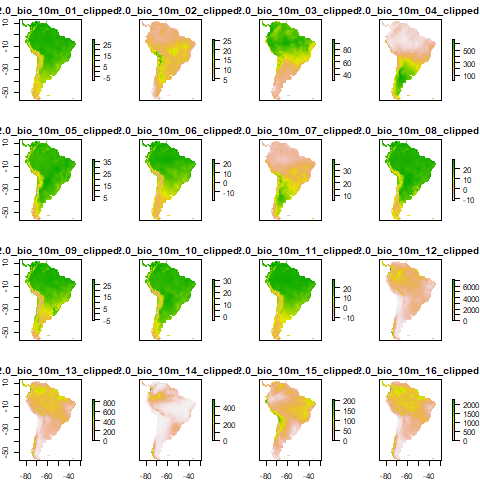

In [37]:
%R plot(predictors)

Now comes the step in which we create the model with bioclim by calling *bioclim(...)* with our raster stack and observation points. The result is a Bioclim object that contains all the properties of the model:

In [38]:
%R bc <- bioclim(predictors, acaulePoints)

<rpy2.robjects.methods.RS4 object at 0x000001F1F0B21288> [RTYPES.S4SXP]
R classes: ('Bioclim',)

The *pairs(...)* function can be used to plot the obervation data for pairs of predictor variables (left bottom half of the matrix), together with correlation coefficients (top right half of the matrix):

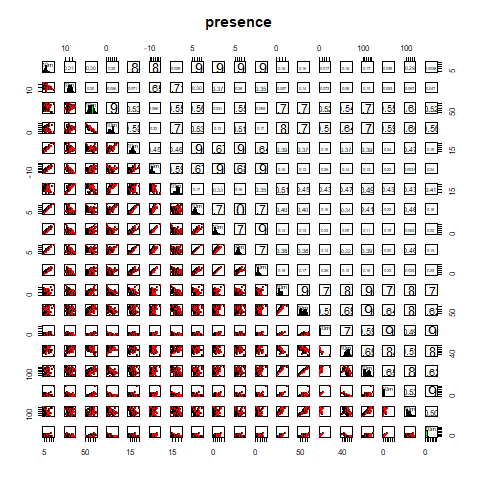

In [39]:
%R pairs(bc)

We can also use the *response(...)* function to have a look at what the model predicts about the likelihood of Solanum Acaule occurring for different values of the individual predictor variables X (assuming all other variables are at their median value):

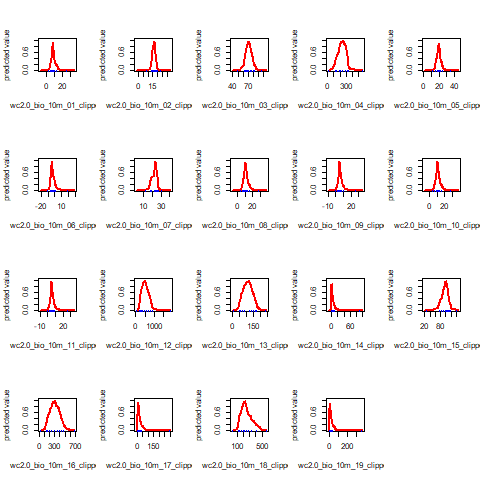

In [40]:
%R response(bc)

Now we finally use the model we created to make a prediction of the species distribution over the project area of South America. In principle, we could use a different input raster stack, for instance to produce a prediction for a different time or a hypothetical one assuming bioclimatic variables would change in a certain way. However, we will simply use our rasters from the *predictors* variable again, meaning we will use the observations to make a prediction for where else one may be able to find Solanum Acaule. For this, we use the dismo *predict(...)* function with *predictors* and our bioclim model in variable *bc*: 

In [41]:
%R pb <- predict(predictors, bc, progress='')
%R pb

<rpy2.robjects.methods.RS4 object at 0x000001F1EF76C748> [RTYPES.S4SXP]
R classes: ('RasterLayer',)

The result is a new RasterLayer object that contains the prediction in form likelihood values for the cells. We can use *plot(...)* to visualize the output raster. In the following, we show two plots, the raw likelihood values and a version showing all cells with a raster value > 0.1 in green.

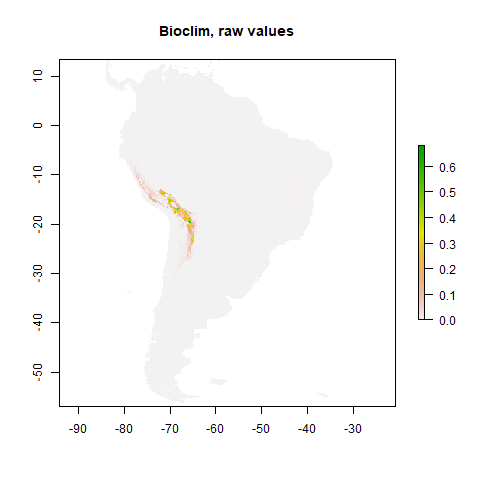

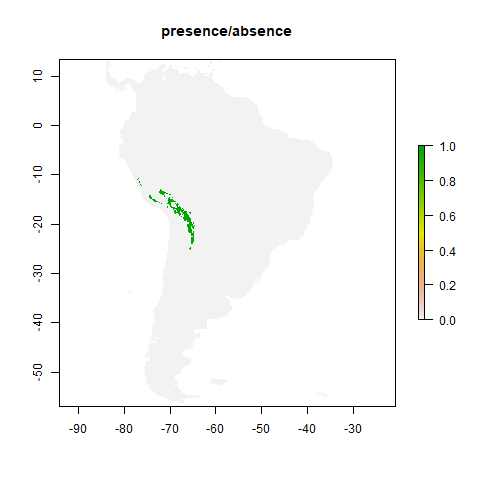

In [42]:
%R par(mfrow=c(1,2))
%R plot(pb, main='Bioclim, raw values')     # plot raw likelihood values
%R plot(pb > 0.1, main='presence/absence')  # plot with cells > 0.1

To be able to use the prediction raster in a map visualization, we now write it to a new output shapefile in our workspace folder:

In [43]:
%R writeRaster(pb, file.path(workspace, predictionRasterFile), overwrite = T)

<rpy2.robjects.methods.RS4 object at 0x000001F1E3DF7988> [RTYPES.S4SXP]
R classes: ('RasterLayer',)

With creating this output file of the bioclim prediction, the R part of this project is completed and we move back to Python for creating a final map visualization of the outcome.

### 6. Postprocessing and visualization of the results with ArcGIS Online
We now have created our bioclim species distribution model and created a raster predicting the likelihood of Solanum Acaule over the entire area of South America. The last things we want to do are creating a Shapefile version of our observation data frame and prediction raster and then using these to generate a simple interactive map representation in our notebook with the help of ESRI's ArcGIS API for Python. The map will have two layers, one with the observation point features and one with a polygonized version of our prediction raster. The reason why we are using a polygonized version of the raster is that there is no simple support for including a raster data set into a ArcGIS Online based map. There is the option to include tile maps and some other image based layer approaches but all of these would require more processing and hosting work than we want to cover in this walkthrough. The map visualization will require that the shapefiles for the two layers are uploaded to ArcGIS Online as .zip files. So we first will produce shapefiles and zipped versions for these two layers.

#### 6.1 Create zipped point shapefile for acaule observation data using GeoPandas
Pandas is great for manipulating general table data but it does not provide support for handling geometry information and reading from or writing to shapefiles. For that we will need the geopandas package which has been built on top of pandas and, in addition, uses the Shapely package for creating and maintaining point, polyline, polygon, and other geometric objects. This will allow us to replace the 'lat' and 'lon' columns in *acauleClean* with a geometry column containing actual Point objects. We start by imporating geopandas and the Shapely Point class, and setting up a dictionary representation for a EPSG:4326 coordinate reference system to be used with geopandes. 

In [44]:
import geopandas as gpd
from shapely.geometry import Point

crs4326 = 'epsg:4326'      # geopandas crs specification for EPSG:4326

Now, we will create a list of Point objects based on the lon and lat coordinates in each row. For that we first apply the *zip(...)* function that takes two lists and turns them into a list of pairs and then use list comprehension to give each pair to the Shapely *Point(...)* function to get a list of corresponding Point objects. 

In [45]:
# create list of Point objects from lon and lat columns
geometryList = [Point(p) for p in zip(acauleClean.lon, acauleClean.lat)]       # create point list from lon, lat pairs created with zip (...)

# print first 6 elements
print(geometryList[0:6])

# print coordinates
print(*geometryList[0:6], sep='\n')                                              

[<shapely.geometry.point.Point object at 0x000001F1F52F0988>, <shapely.geometry.point.Point object at 0x000001F1F525DBC8>, <shapely.geometry.point.Point object at 0x000001F1EF667808>, <shapely.geometry.point.Point object at 0x000001F1F52F0AC8>, <shapely.geometry.point.Point object at 0x000001F1F52F0B08>, <shapely.geometry.point.Point object at 0x000001F1F52F0BC8>]
POINT (-66.09999999999999 -21.9)
POINT (-71 -13.5)
POINT (-65.13330000000001 -22.2666)
POINT (-66.95 -18.6333)
POINT (-65.88330000000001 -18.8)
POINT (-65.88330000000001 -18.8333)


The output above should consist of a list of six Shapely Point objects, the first six elements in our *geometry* list, followed by a more readable version showing the actual coordinates produced by the second print using the star to unpack the list first. We can now create a geopandas DataFrame object from the pandas data frame in variable *acauleGeo* by first dropping the lat and lon columns and then invoking GeoDataFrame with the CRS specification we prepared in variable *crs4326* and the list of Point objects in variable *geometryList*:

In [46]:
acauleGeo = gpd.GeoDataFrame(acauleClean.drop(['lon', 'lat'], axis=1), crs=crs4326, geometry=geometryList)
acauleGeo.head()

,species,continent,country,adm1,adm2,locality,coordUncertaintyM,alt,institution,collection,...,gbifNotes,downloadDate,maxElevationM,minElevationM,maxDepthM,minDepthM,ISO2,cloc,country_geocoding,geometry
1,Solanum acaule Bitter,South America,Argentina,Jujuy,Santa Catalina,Santa Catalina: camino de salida del pueblo,None,NaN,NY,Herbarium,...,Data from GBIF data index - original values.,15721.0,None,None,None,None,AR,"Santa Catalina: camino de salida del pueblo, J...",Argentina,POINT (-66.10000 -21.90000)
2,Solanum acaule Bitter,South America,Peru,Cusco,Canchis,"Dist. Sicuani, Santa Barbara, Mumurani.",None,4500.0,NY,Herbarium,...,Data from GBIF data index - original values.,15721.0,4500,4500,None,None,PE,"Dist. Sicuani, Santa Barbara, Mumurani., Cusco...",Peru,POINT (-71.00000 -13.50000)
3,Solanum acaule f. acaule,None,Argentina,None,None,"Province: Salta, Department: Santa Victoria, E...",None,3800.0,NLD037,CGN-PGR,...,Data from GBIF data index - original values.,15721.0,None,3800,None,None,AR,"Province: Salta, Department: Santa Victoria, E...",Argentina,POINT (-65.13330 -22.26660)
4,Solanum acaule f. acaule,None,Bolivia,None,None,"Department: Oruro, Province: Poopo, farm (Fink...",None,3700.0,NLD037,CGN-PGR,...,Data from GBIF data index - original values.,15721.0,None,3700,None,None,BO,"Department: Oruro, Province: Poopo, farm (Fink...",Bolivia,POINT (-66.95000 -18.63330)
5,Solanum acaule f. acaule,None,Bolivia,None,None,"Department: Potosi, Province: Chayanta, 37km f...",None,4080.0,NLD037,CGN-PGR,...,Data from GBIF data index - original values.,15721.0,None,4080,None,None,BO,"Department: Potosi, Province: Chayanta, 37km f...",Bolivia,POINT (-65.88330 -18.80000)


If you scroll all the way to the right in the table output produced above, you will see the new 'geometry' column with the Point objects. Just as a sidenote, here is how we can plot the content of our Point based geopandas data frame with matplotlib:

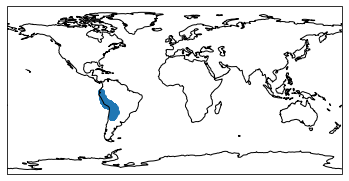

In [47]:
m = plt.axes(projection=ccrs.PlateCarree())
m.coastlines()
m.set_global()
m.scatter(acauleGeo.geometry.x,acauleGeo.geometry.y)
plt.show()

We can now use the geopandas *to_file(...)* method to write the data frame to a new shapefile. The name of the output shapefile has been defined at the beginning of the notebook in variable *acauleObservationShapefile*.

In [50]:
acauleGeo.to_file( os.path.join(workspace, acauleObservationShapefile), driver = 'ESRI Shapefile') 

The new shapefile should now be in your workspace folder. Feel free to check it out by opening it in a GIS software of your choice. 

As mentioned, we also need a zip file version of the shapefile to upload to ArcGIS Online. Let's use Python code to produce this as well with the help of the zipfile package. Since we will need to do this for two different shapefiles, we define a function *zipShapefile(name)* that takes a filename without extension and then creates a .zip file from those files that have the same name but different three letter extensions. We will use a regular expression again to get all these files, while at the same time making sure not to include a .zip file with that name that may already be in that folder.

In [51]:
import zipfile

# function to create zipped shapefile for a given filename without extension
def zipShapefile(name):
    compiledRE = re.compile(name+'(?!.zip)\....$')
    with zipfile.ZipFile( os.path.join(workspace, name + '.zip'), 'w', zipfile.ZIP_DEFLATED) as zf:  # create zipfile
        for file in os.listdir(workspace):                                                           # go through files in workspace
            if compiledRE.match(file):                                                               # test whether file is part of the shapefile to be zipped
                zf.write(os.path.join(workspace,file),file,zipfile.ZIP_DEFLATED)                     # add file to zipfile
                
# create zipped version of observation shapefile
zipShapefile( os.path.splitext(acauleObservationShapefile)[0] )

If you check your workspace folder, you should now see the newly created .zip file there and it should contain the different files making up the shapefile. 

#### 6.2 Polygonize prediction raster to visualize it with AGOL
As we mentioned, the simplest way to get our prediction result included in our final map visualization is by creating a vector version of it that polygonizes the raster based on the cell values. For this, we will first apply a reclassification to the raster that classifies the raster values into six classes:
* 5: likelihood > 0.5
* 4: likelihood > 0.3 and <= 0.5
* 3: likelihood > 0.2 and <= 0.3
* 2: likelihood > 0.1 and <= 0.2
* 1: likelihood < 0.01 and <= 0.1
* 0: likelihood <= 0.01

The resulting polygon vector data set will then consist of polygons formed by adjacent raster cells with the same reclassified value. To perform the reclassification and polygonization we will use GDAL again. For the reclassification we will use the raster algebra operators provided by GDAL and for the polygonization we will apply the *Polygonize(...)* function (Section 3.9.2 of the lesson materials. We start by opening the prediction raster file with GDAL:

In [52]:
from osgeo import gdal

raster = gdal.Open(os.path.join(workspace, predictionRasterFile))  # open raster file
projection = raster.GetProjection()                                # get projection of raster file

print(projection)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


Next, we prepare the output shapefile by creating the shapefile itself, followed by creating a layer in the shapefile, and adding a new attribute 'DN' to that layer for storing the raster value for each of the polygon features. 

In [53]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr   # module for working with projections

drv = ogr.GetDriverByName('ESRI Shapefile')                                   # set up driver object to read/write shapefiles
sr = osr.SpatialReference(projection)                                         # create OSR spatial reference object 
output = drv.CreateDataSource( os.path.join(workspace, predictionShapefile )) # create shapefile for polygonized output
outLayer = output.CreateLayer('bc_pred_polygonized', srs=sr)                  # add new layer
newField = ogr.FieldDefn('DN', ogr.OFTReal)                                   # define a float field forst storing raster values 
outLayer.CreateField(newField)                                                # add new field to layer

0

Now we perform the raster reclassification for the raster band in variable *band*. Since we do not want to modify the original raster file, we first create an in memory copy of the file. Then we get the first band and turn it into an array of values in variable *data* to which we can then apply raster algebra operations. Once the array has been reclassified, we write the data back to the raster band in *band* and call the *Polygonize(...)* function to perform the polygonization of *band* and write the resulting polygon features to *outLayer*, the only layer in our newly created shapefile.

In [54]:
tmpRaster = gdal.GetDriverByName('MEM').CreateCopy('', raster, 0)  # create in-memory copy
band = tmpRaster.GetRasterBand(1)                                  # get the first (and only) band

# get raster as Array and reclassify 
data = band.ReadAsArray()  
data[data > 0.5] = 5
data[(data <= 0.5) & (data > 0.3)] = 4
data[(data <= 0.3) & (data > 0.2)] = 3
data[(data <= 0.2) & (data > 0.1)] = 2
data[(data <= 0.1) & (data > 0.01)] = 1
data[data <= 0.01] = 0

# write reclassified Array back to raster band
band.WriteArray(data)

# polygonize the raster band and write the result to outLayer 
gdal.Polygonize(band, None, outLayer, 0, [])

0

Right now, the polygons created from the raster will cover the entire rectangular area containing South America with most of this area having extremely low likelihood (class 0 in our reclassification). For the map visualization we want to produce, it's better to remove these polygons and just work with those from classes 1 and above. As a last step before closing the shapefile, we therefore loop through the polygon featues in *outLayer* and remove those that have a 'DN' attribute value of 0:

In [55]:
# loop through resulting polygon features and delete those that have a DN value of 0.0 
for i in range(outLayer.GetFeatureCount()):
    inFeature = outLayer.GetFeature(i)        # get i-th feature from layer
    value=inFeature.GetField('DN')            # get DN value
    if value == 0.0:
        outLayer.DeleteFeature(i)             # delete feature from layer

output.Destroy()                              # close shapefile and clean up
raster = None

This would be a good moment to check out the shapefile we produced in a GIS. When coloring the polygons based on the 'DN' field, the result should look somewhat similar to this:
<img src="https://www.dropbox.com/s/7l9vg4qegeo87no/489_L3_prediction.PNG?raw=1" style="width: 200px"/>

The last thing we need to do is produce a zipped version of the shapefile by calling our previously defined zipShapefile function:

In [56]:
zipShapefile( os.path.splitext(predictionShapefile)[0] )

#### 6.3 Upload and publish to AGOL 
We now have our two shapefiles ready in zipped form, so we can use the ArcGIS API for Python to establish a connection to your ArcGIS Online account and publish them as feature services that we can use in our map visualization. We start by creating a GIS object connected to your ArcGIS online account using the approach described in section 3.10 of the lesson materials of authenticating with our PSU login. Remember that you will get a code that you will have to paste in at the prompt. If everything works correclty, the following code should produce the output "GIS@https://www.arcgis.com". 

In [57]:
import arcgis
from arcgis.gis import GIS

# connect to AGOL using your PSU login
gis = GIS('https://pennstate.maps.arcgis.com', client_id='lDSJ3yfux2gkFBYc') 
gis

Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://pennstate.maps.arcgis.com/sharing/rest//oauth2/authorize?response_type=code&client_id=lDSJ3yfux2gkFBYc&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=8BpI81eILkU24th7Oh3N1DuOvuRkuu
Enter code obtained on signing in using SAML: ········


C:\Users\jow\anaconda3\envs\AC37\lib\site-packages\urllib3\connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pennstate.maps.arcgis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


GIS @ https://pennstate.maps.arcgis.com version:10.2

The following piece of code is for making sure that we don't have any acaule observation and prediction shapefiles or feature services already on AGOL from previous runs of the notebook. This would lead to errors in the following code cells when trying to upload and publish under the same names, so we better start from scratch. The code we use is built around the ArcGIS *search(...)* function for finding content items and two auxiliary functions: The first one, *searchAGOL(...)* simply builds a query from given title, owner, and itemType parameters and then returns a list of content items found by calling *gis.content.search(...)*. The second auxiliary function, *deleteIfExistsOnAGOL(...)* uses this function and then deletes all item found from AGOL by invoking the *delete(...)* method of the items. We apply this function to shapefiles and feature services of both acaule observation and prediction.

In [59]:
# search for content in your gis with a query built from tilte, owner and item type
def searchAGOL(title, owner, itemType):
    return gis.content.search(query='title:'+title+' owner:'+owner, item_type=itemType)

# test whether items exist on AGOL for given title, owner, and item type and if so, delete them from AGOL
def deleteIfExistsOnAGOL(title, owner, itemType):
    result = searchAGOL(title, owner, itemType)   # search item
    print('Found items for title='+title+', owner='+owner+', itemType='+itemType+':')
    print(result)
    for item in result:                           # delete items found
        item.delete()
        print('Item ' + item.title + ' has been deleted.')

# delete existing acaule observation and prediction shapefiles and feature layers on AGOL
deleteIfExistsOnAGOL(os.path.splitext(acauleObservationShapefile)[0], usernameAGOL, 'Shapefile')
deleteIfExistsOnAGOL(os.path.splitext(acauleObservationShapefile)[0], usernameAGOL, 'Feature Service')
deleteIfExistsOnAGOL(os.path.splitext(predictionShapefile)[0], usernameAGOL, 'Shapefile')
deleteIfExistsOnAGOL(os.path.splitext(predictionShapefile)[0], usernameAGOL, 'Feature Service')

Found items for title=acauleObservations_juw30, owner=*_pennstate, itemType=Shapefile:
[]
Found items for title=acauleObservations_juw30, owner=*_pennstate, itemType=Feature Service:
[]
Found items for title=bioclimPrediction_juw30, owner=*_pennstate, itemType=Shapefile:
[]
Found items for title=bioclimPrediction_juw30, owner=*_pennstate, itemType=Feature Service:
[]


The output of the previous cell will tell you which shapefiles and features services were deleted. If this is the first time you run this part of the notebook code, no items should be found on AGOL, so you will see empty lists [] in the output and no "Item ... has been deleted" messages. Just to make absolutely sure, let's use *searchAGOL(...)* to check again. The output at this point should be for empty lists [] or else something went wrong and you may have to manually delete the items using the AGOL web site.

In [60]:
print(searchAGOL(os.path.splitext(acauleObservationShapefile)[0], usernameAGOL, 'Shapefile'))
print(searchAGOL(os.path.splitext(acauleObservationShapefile)[0], usernameAGOL, 'Feature Service'))
print(searchAGOL(os.path.splitext(predictionShapefile)[0], usernameAGOL, 'Shapefile'))
print(searchAGOL(os.path.splitext(predictionShapefile)[0], usernameAGOL, 'Feature Service'))

[]
[]
[]
[]


Now, we can upload our two zipped shapefiles to AGOL using the *gis.content.add(...)* method. Since we only want to use these layers privately for this notebook and AGOL is smart enough to figure out that we are adding a zipped shapefile, we do not need to provide any property information and, hence, the first parameter of the calls is an empty dictionary {}:

In [61]:
acauleAGOLShapefile = gis.content.add({'type':'Shapefile'}, os.path.join(workspace, os.path.splitext(acauleObservationShapefile)[0]+'.zip'))
predictionAGOLShapefile = gis.content.add({'type':'Shapefile'}, os.path.join(workspace, os.path.splitext(predictionShapefile)[0]+'.zip'))

Just to be extra careful, let's check the gis content again for shapefiles. This time it should show us the two items for the uploaded shapefiles as 

`[<Item title:"acauleObservations*" type:Shapefile owner:<your AGOL ID>>]
[<Item title:"bioclimPrediction*" type:Shapefile owner:<your AGOL ID>>]`

In [62]:
print(searchAGOL(os.path.splitext(acauleObservationShapefile)[0], usernameAGOL, 'Shapefile'))
print(searchAGOL(os.path.splitext(predictionShapefile)[0], usernameAGOL, 'Shapefile'))

[<Item title:"acauleObservations_juw30" type:Shapefile owner:juw30_pennstate>]
[<Item title:"bioclimPrediction_juw30" type:Shapefile owner:juw30_pennstate>]


To use the shapefiles in an AGOL map, they need to be published as feature services first. This is done by calling the *publish()* method for each of them:

In [63]:
acauleAGOLFeatureService = acauleAGOLShapefile.publish()
predictionAGOLFeatureService = predictionAGOLShapefile.publish()

Again we make sure that this worked out correctly, this time by checking for the feature services newly published feature services that should show up in the output as

`[<Item title:"acauleObservations*" type:Feature Layer Collection owner::<your AGOL ID>>]
[<Item title:"bioclimPrediction*" type:Feature Layer Collection owner:<your AGOL ID>>]`

In [64]:
print(searchAGOL(os.path.splitext(acauleObservationShapefile)[0], usernameAGOL, 'Feature Service'))
print(searchAGOL(os.path.splitext(predictionShapefile)[0], usernameAGOL, 'Feature Service'))

[<Item title:"acauleObservations_juw30" type:Feature Layer Collection owner:juw30_pennstate>]
[<Item title:"bioclimPrediction_juw30" type:Feature Layer Collection owner:juw30_pennstate>]


Since the ArcGIS Python API includes widgets for content items, we can also show these in a nice way in this notebook including links and additional information:

In [65]:
acauleAGOLFeatureService

<Item title:"acauleObservations_juw30" type:Feature Layer Collection owner:juw30_pennstate>

In [66]:
predictionAGOLFeatureService

<Item title:"bioclimPrediction_juw30" type:Feature Layer Collection owner:juw30_pennstate>

#### 6.4 Final interactive map visualization
With the two shapefiles published as feature services, the last step that remains is to create a map widget that embeds an ineractive AGOL map with our two layers into this notebook. This is straightforward: We first create the ArcGIS map object with *gis.map()* using streets as the basemap option and then add the map as a widget to the notebook:

In [67]:
finalMap = gis.map()
finalMap.basemap = 'streets'
finalMap

MapView(layout=Layout(height='400px', width='100%'))

After executing the cell above, you should now see a world map that you can pan and zoom with your mouse. Since this interactive map will not be visible in an HTML export or other static export of this notebook, we are including an image showing the map below:
<img src="https://www.dropbox.com/s/dgtk1mr7an9j68c/489_L3_walkthroughfinalmap.PNG?raw=1" style="width: 500px"/>

The static image already shows the map with our observation and prediction layers but we actually have not added these yet. We add the prediction layer with the *add_layer(...)* method using the ClassedColorRenderer to color the polygons based on the values in the DN field and with 0.7 opacity. The layer will appear in the map widget above. (If for some reason any of the layers in this and the next step don't show up immediately, wait a moment and run the cell again. Also the colors may be different in your case.) 

In [68]:
finalMap.add_layer(predictionAGOLFeatureService,{
               'renderer': 'ClassedColorRenderer', 
               'field_name': 'DN', 
               'opacity':0.7
              })

As a last step, we add the acaule observation point layer on top of the prediction:

In [69]:
finalMap.add_layer(acauleAGOLFeatureService,{
               "opacity":0.7
              })

We now have a map visualization of our little species modeling project that shows the observation data we started with and resulting distribution prediction and that can be used to inspect the data and results. Clicking on any of the observation points in the map will open a popup window showing all the attributes of that observation point. Clicking any polygon of the prediction layer allows us to check out the DN class this polygon belongs to from the reclassifcation we applied in Section 6.2.

In [72]:
user = gis.users.get('juw30_pennstate')
user

Exception: Invalid token.
(Error Code: 498)